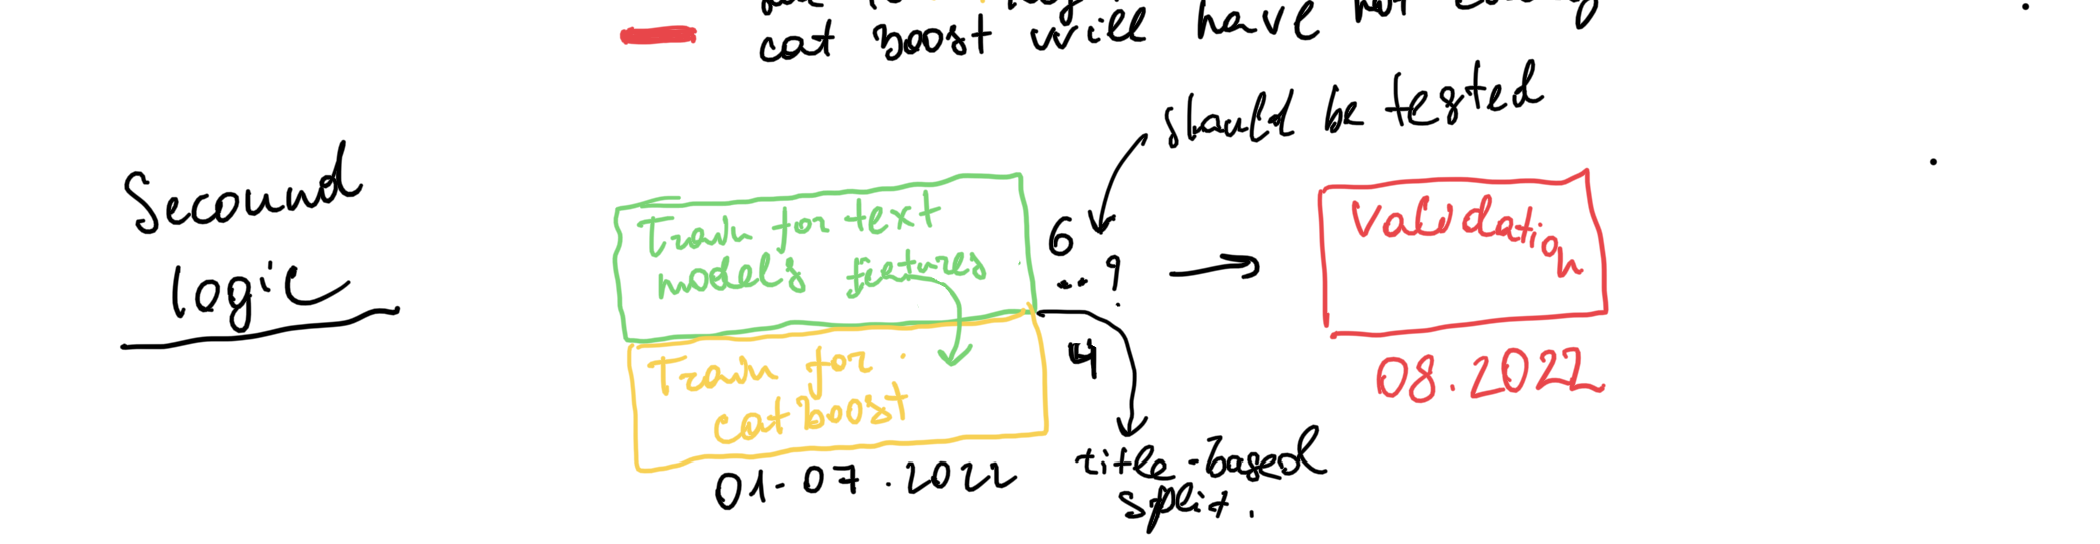

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax

# loading data

cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_train = "../data/multilingual_train/processed_train_{}.csv".format("_".join(cc_codes))
filename_pattern_test = "../data/multilingual_train/processed_test_{}.csv".format("_".join(cc_codes))

train_df = pd.read_csv(filename_pattern_train)
test_df = pd.read_csv(filename_pattern_test)

train_df = train_df[train_df["is_text_train"] == 0]

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Title feature recalculation:

In [2]:
model_path = "../title_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-19270"
tokenizer = AutoTokenizer.from_pretrained(
    model_path, truncation=True, max_length=512, device="gpu"
)
model = BertForSequenceClassification.from_pretrained(model_path).to("cuda")
pipe = pipeline(
    task="text-classification", model=model, tokenizer=tokenizer, batch_size=1, device=0
)

In [3]:
train_df.page_title = train_df.page_title.apply(lambda x: x.replace("_", " "))

text_to_process = train_df.page_title.unique()
text_features_inter = pipe(
        list(text_to_process),
        return_all_scores=True,
        function_to_apply="none",
        truncation=True,
        max_length=512,
        batch_size=1000,
)
text_features = {text: a[0]['score'] for text, a in zip(text_to_process, text_features_inter)}
train_df["bert_title_score"] = train_df.page_title.apply(lambda x: text_features[x])

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [4]:
test_df.page_title = test_df.page_title.apply(lambda x: x.replace("_", " "))

text_to_process = test_df.page_title.unique()
text_features_inter = pipe(
        list(text_to_process),
        return_all_scores=True,
        function_to_apply="none",
        truncation=True,
        max_length=512,
        batch_size=1000,
)
text_features = {text: a[0]['score'] for text, a in zip(text_to_process, text_features_inter)}
test_df["bert_title_score"] = test_df.page_title.apply(lambda x: text_features[x])

# Feature renaming for convention:

In [5]:
features_renaming = dict()

old_insert = [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
new_insert = [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})

old_insert = [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]]
new_insert = [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]]
features_renaming.update({k:v for k,v in zip(old_insert, new_insert)})


In [6]:
feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']

features_renaming.update({old: "_".join([old.split("_")[1], old.split("_")[0]]) for old in feat})

In [7]:
new_columns = [features_renaming.get(x, x) for x in train_df.columns]
train_df.columns = new_columns

new_columns = [features_renaming.get(x, x) for x in test_df.columns]
test_df.columns = new_columns

# Features preparation: 

In [8]:
feat = ['Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove']
features_actions = ["_".join([old.split("_")[1], old.split("_")[0]]) for old in feat]

features_list = [
       'wiki_db',
       # 'page_title', 
       # 'page_revision_count', 
       'revision_text_bytes_diff',
       'is_mobile_edit', 'is_mobile_web_edit',
       'is_visualeditor', 'is_wikieditor',
       'is_ios_app_edit',
       # 'texts_removed', 'texts_insert', 'texts_change', 'actions',
       # 'categories', 'wikidata_item_id', 
       # 'page_region', 'country_iso_code',
       # 'region_iso_code', 'city', 'latitude', 'longitude',
] + features_actions\
+ [f"bert_insert_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_change_{c}" for c in ["s0_max", "s1_max", "p0_max", "p1_max", "s0_mean", "s1_mean", "p0_mean", "p1_mean"]] \
+ [f"bert_comment_{c}" for c in ["s0", "s1", "p0", "p1"]] \
+ ["bert_title_score"]

# Modeling:

In [10]:
BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True

is_text_train_filter = 'is_text_train'
balancing_column = 'is_balanced'
target_column = 'revision_is_identity_reverted'
features = features_list

X_train, X_test, y_train, y_test = train_test_split(train_df[features].fillna(-1), 
                                                    train_df[target_column], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=train_df[target_column])


cat_features = [
    'wiki_db',
    # 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_ios_app_edit',
    # 'page_region', 'country_iso_code',
    # 'region_iso_code', 'city'
]

train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)
test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model.best_score_

0:	learn: 0.6907628	test: 0.6907358	best: 0.6907358 (0)	total: 285ms	remaining: 23m 46s
100:	learn: 0.5829129	test: 0.5811591	best: 0.5811591 (100)	total: 14.6s	remaining: 11m 49s
200:	learn: 0.5577620	test: 0.5552255	best: 0.5552255 (200)	total: 28s	remaining: 11m 8s
300:	learn: 0.5469848	test: 0.5440997	best: 0.5440997 (300)	total: 41.3s	remaining: 10m 44s
400:	learn: 0.5410238	test: 0.5378958	best: 0.5378958 (400)	total: 54.7s	remaining: 10m 27s
500:	learn: 0.5371821	test: 0.5338517	best: 0.5338517 (500)	total: 1m 7s	remaining: 10m 10s
600:	learn: 0.5345291	test: 0.5311057	best: 0.5311057 (600)	total: 1m 20s	remaining: 9m 52s
700:	learn: 0.5324695	test: 0.5289597	best: 0.5289597 (700)	total: 1m 34s	remaining: 9m 39s
800:	learn: 0.5307481	test: 0.5272114	best: 0.5272114 (800)	total: 1m 47s	remaining: 9m 25s
900:	learn: 0.5293771	test: 0.5258292	best: 0.5258292 (900)	total: 2m	remaining: 9m 10s
1000:	learn: 0.5282079	test: 0.5246872	best: 0.5246872 (1000)	total: 2m 14s	remaining: 8m 5

{'learn': {'Accuracy:use_weights=false': 0.7447058117391565,
  'Precision:use_weights=false': 0.7187615186140803,
  'Recall:use_weights=false': 0.7144352559405422,
  'Logloss:use_weights=true': 0.510581891883873,
  'Accuracy:use_weights=true': 0.7420422769001115,
  'Logloss:use_weights=false': 0.5095735311606382,
  'Logloss': 0.510581891883873,
  'Precision:use_weights=true': 0.7561874121775286,
  'Recall:use_weights=true': 0.7144352559405422,
  'F1:use_weights=false': 0.7165918576265848,
  'F1:use_weights=true': 0.7347186454692872},
 'validation': {'Accuracy:use_weights=false': 0.7453878767044804,
  'Recall:use_weights=false': 0.7189549588723412,
  'Precision:use_weights=false': 0.7178782067518182,
  'Logloss:use_weights=true': 0.5106440196883438,
  'Accuracy:use_weights=true': 0.7430588735957047,
  'AUC': 0.823903605834813,
  'Logloss:use_weights=false': 0.5097133984114494,
  'Logloss': 0.5106440196883438,
  'Precision:use_weights=true': 0.7553816421673007,
  'Recall:use_weights=true

In [11]:
class_weights

{0: 0.9120090371338617, 1: 1.1067828068508483}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,33492.0,0.347299,0.206350,0.002201,0.182534,0.310749,0.483885,0.996032
1,27597.0,0.654228,0.242942,0.019327,0.469027,0.680292,0.871931,0.999817


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

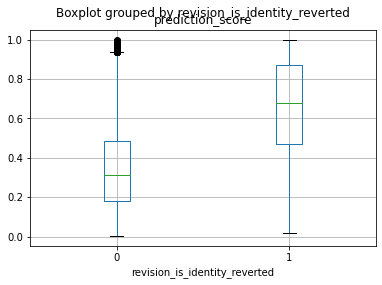

In [12]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(test_data)[:, 1],
                       "revision_is_identity_reverted": y_test
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


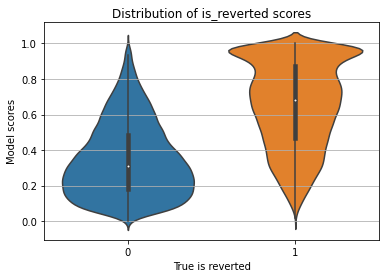

In [13]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [14]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train_data), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
1,8.249631,revision_text_bytes_diff
0,7.706234,wiki_db
115,6.225138,bert_title_score
100,6.164511,bert_insert_s1_mean
104,5.069545,bert_change_s1_max
...,...,...
85,0.000000,move_Whitespace
70,0.000000,remove_Table Element
25,0.000000,move_Gallery
78,0.000000,remove_Text


# Hold-out validation

- actions features 0.6823 ->  0.7091 (baseline)


In [15]:
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

In [16]:
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.5344398647367434,
 'AUC': 0.8016025270458926,
 'Precision': 0.6814126791464865,
 'Recall': 0.6882069317601679,
 'F1': 0.6847929533769511,
 'Accuracy': 0.7292822013705288}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,143370.0,0.351818,0.208559,0.003281,0.184523,0.313902,0.490972,0.996786
1,88145.0,0.627757,0.239453,0.003711,0.442763,0.651447,0.826101,0.999882


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

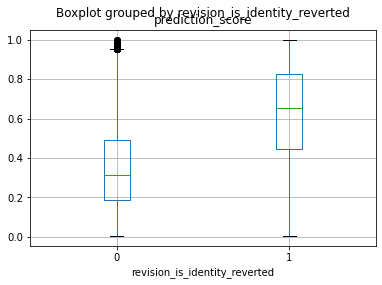

In [17]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


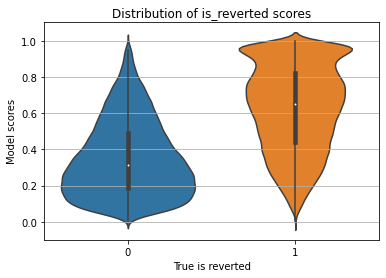

In [18]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [19]:
pd.DataFrame({'feature_importance': model.get_feature_importance(hold_out_data), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(30)

,feature_importance,feature_names
0,8.663879,wiki_db
1,7.441857,revision_text_bytes_diff
115,6.854270,bert_title_score
100,5.359846,bert_insert_s1_mean
104,4.182879,bert_change_s1_max
107,4.100232,bert_change_s0_mean
5,3.246991,is_wikieditor
3,3.166597,is_mobile_web_edit
106,3.138514,bert_change_p1_max
111,3.120606,bert_comment_s0


# Balanced hold-out

In [20]:
hold_out_data = Pool(
    data=test_df[test_df.is_balanced == 1][features].fillna(-1),
    label=test_df[test_df.is_balanced == 1][target_column],
    cat_features=cat_features
)
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.5712764932807263,
 'AUC': 0.7694565981135288,
 'Precision': 0.7433140554188177,
 'Recall': 0.6882069317601679,
 'F1': 0.7146998053057974,
 'Accuracy': 0.698769947302476}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,88145.0,0.390110,0.204953,0.004231,0.229798,0.358700,0.532000,0.996786
1,88145.0,0.627757,0.239453,0.003711,0.442763,0.651447,0.826101,0.999882


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


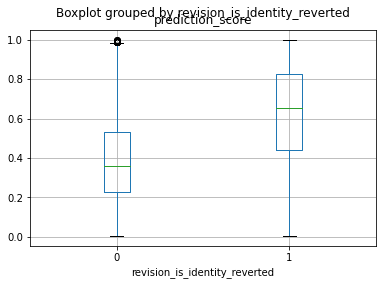

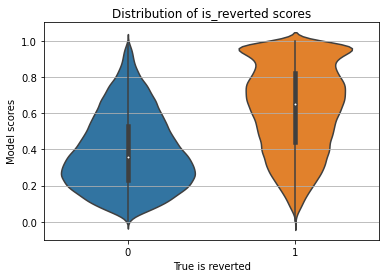

In [21]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[test_df.is_balanced == 1][target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [22]:
model.save_model('classifier') 